In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import collections
from powerlaw import Fit
from itertools import combinations
from collections import defaultdict
import matplotlib.pyplot as plt
from scipy.sparse.linalg import eigs
from scipy.sparse import csc_matrix
from centralities import compute_all_centralities
import community as community_louvain
from matplotlib.colors import ListedColormap
from scipy.sparse.linalg import eigs
from networkx.algorithms.centrality import betweenness_centrality
import time

Preprocessing rawrecipes.csv

In [2]:
df = pd.read_csv('data/RAW_recipes.csv')

In [3]:
display(df.head())
df.shape

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8


(231637, 12)

In [4]:
# removing rows with missing ingridients
df = df.dropna(subset=['ingredients'])

In [5]:
df.shape

(231637, 12)

In [6]:
# Convert ingredients to lowercase and remove leading/trailing spaces
df['ingredients'] = df['ingredients'].apply(lambda x: [i.strip().lower() for i in eval(x)])

In [7]:
# Count ingredient frequencies
ingredient_counts = {}
for ingredients in df['ingredients']:
    for ingredient in ingredients:
        ingredient_counts[ingredient] = ingredient_counts.get(ingredient, 0) + 1

In [8]:
min_occurrences = 5
df['ingredients'] = df['ingredients'].apply(lambda x: [i for i in x if ingredient_counts[i] >= min_occurrences])

In [9]:
# Remove recipes that become empty after filtering
df = df[df['ingredients'].apply(len) > 0]

In [10]:
# Save preprocessed data
df.to_csv('processed_raw_recipes.csv', index=False)

print("Preprocessing completed. Cleaned dataset saved as 'PP_recipes.csv'.")

Preprocessing completed. Cleaned dataset saved as 'PP_recipes.csv'.


Construct Network and Analyze Degree Distribution

In [11]:
# Load preprocessed dataset
df = pd.read_csv('data/processed_raw_recipes.csv')

In [12]:
df

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'eggs', 'milk', 'salt...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8
...,...,...,...,...,...,...,...,...,...,...,...,...
231632,zydeco soup,486161,60,227978,2012-08-29,"['ham', '60-minutes-or-less', 'time-to-make', ...","[415.2, 26.0, 34.0, 26.0, 44.0, 21.0, 15.0]",7,"['heat oil in a 4-quart dutch oven', 'add cele...",this is a delicious soup that i originally fou...,"['celery', 'onion', 'green sweet pepper', 'gar...",22
231633,zydeco spice mix,493372,5,1500678,2013-01-09,"['15-minutes-or-less', 'time-to-make', 'course...","[14.8, 0.0, 2.0, 58.0, 1.0, 0.0, 1.0]",1,['mix all ingredients together thoroughly'],this spice mix will make your taste buds dance!,"['paprika', 'salt', 'garlic powder', 'onion po...",13
231634,zydeco ya ya deviled eggs,308080,40,37779,2008-06-07,"['60-minutes-or-less', 'time-to-make', 'course...","[59.2, 6.0, 2.0, 3.0, 6.0, 5.0, 0.0]",7,"['in a bowl , combine the mashed yolks and may...","deviled eggs, cajun-style","['hard-cooked eggs', 'mayonnaise', 'dijon must...",8
231635,cookies by design cookies on a stick,298512,29,506822,2008-04-15,"['30-minutes-or-less', 'time-to-make', 'course...","[188.0, 11.0, 57.0, 11.0, 7.0, 21.0, 9.0]",9,['place melted butter in a large mixing bowl a...,"i've heard of the 'cookies by design' company,...","['butter', 'eagle brand condensed milk', 'ligh...",10


In [13]:
G = nx.Graph()

In [14]:
# Add nodes (ingredients)
for ingredients in df['ingredients']:
    ingredients = eval(ingredients)  # Convert string back to list
    for ingredient in ingredients:
        G.add_node(ingredient)

In [15]:
# Dictionary to store co-occurrence counts
edge_weights = {}

# Compute co-occurrence counts
for ingredients in df['ingredients']:
    ingredients = eval(ingredients)  # Convert string back to list
    for i in range(len(ingredients)):
        for j in range(i + 1, len(ingredients)):
            pair = tuple(sorted([ingredients[i], ingredients[j]]))
            edge_weights[pair] = edge_weights.get(pair, 0) + 1  # Count occurrences

# Normalize weights
max_weight = max(edge_weights.values())  # Get max occurrence for normalization

# Add nodes & weighted edges to graph
for (ingredient1, ingredient2), weight in edge_weights.items():
    G.add_edge(ingredient1, ingredient2, weight=weight / max_weight)  # Normalized weight

In [16]:
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
print(f"Number of Nodes (N): {num_nodes}")
print(f"Number of Edges (E): {num_edges}")

Number of Nodes (N): 8010
Number of Edges (E): 1237243


In [17]:
# Compute degree of each node
degrees = [deg for _, deg in G.degree()]

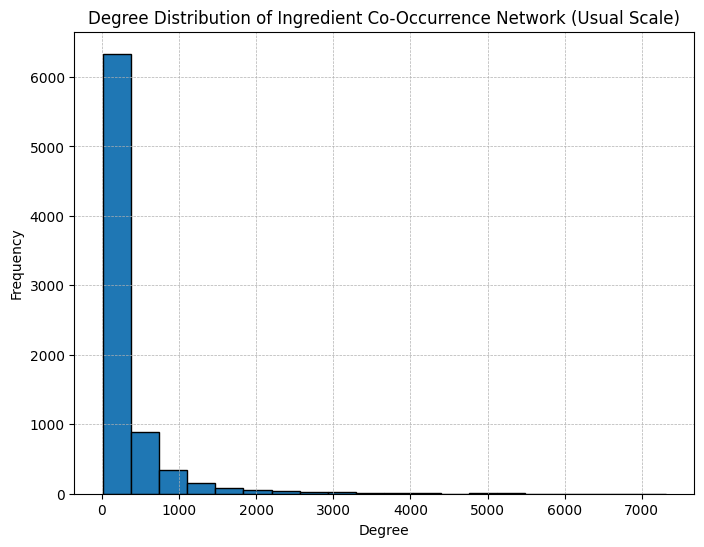

In [18]:
# Plot degree distribution (Usual Scale)
plt.figure(figsize=(8, 6))
plt.hist(degrees, bins=20, edgecolor='black')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution of Ingredient Co-Occurrence Network (Usual Scale)')
plt.grid(True, linestyle="--", linewidth=0.5)
plt.show()

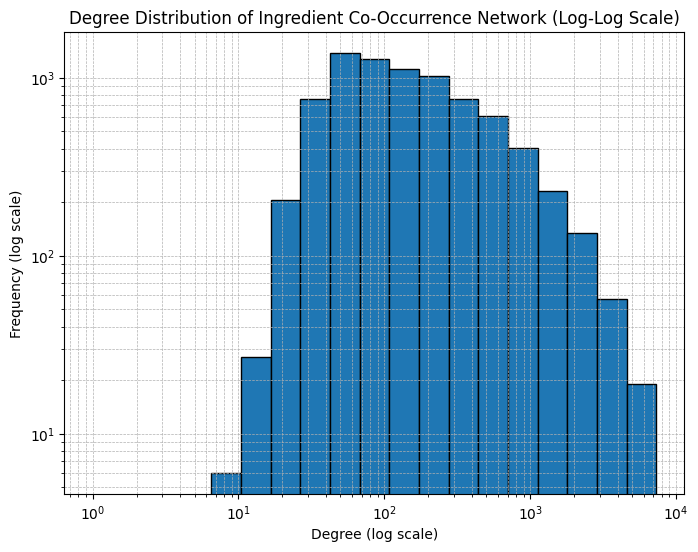

In [19]:
# Plot degree distribution (Log-Log Scale)
plt.figure(figsize=(8, 6))
plt.hist(degrees, bins=np.logspace(np.log10(1), np.log10(max(degrees)), 20), edgecolor='black')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Degree (log scale)')
plt.ylabel('Frequency (log scale)')
plt.title('Degree Distribution of Ingredient Co-Occurrence Network (Log-Log Scale)')
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

In [20]:
def networkx_louvain(G):
    # Requires NetworkX 2.6+
    if nx.is_directed(G):
        G = G.to_undirected()

    # Louvain with resolution parameter (default=1.0)
    communities = list(nx.community.louvain_communities(G, resolution=1.0))
    modularity = nx.community.modularity(G, communities)

    # Convert to partition format
    partition = {}
    for comm_id, nodes in enumerate(communities):
        for node in nodes:
            partition[node] = comm_id

    return communities, modularity


In [21]:
communities, modularity = networkx_louvain(G)

In [22]:
modularity

0.22401382486283697

In [23]:
def visualize_communities(G, partition, modularity=None):
    """Visualize network communities with proper color mapping"""

    # Convert partition to sequential integer IDs if needed
    unique_comms = sorted(set(partition.values()))
    num_comms = len(unique_comms)
    comm_map = {old_id: new_id for new_id, old_id in enumerate(unique_comms)}
    node_colors = [comm_map[partition[n]] for n in G.nodes()]

    print(f"Visualizing {num_comms} communities with original IDs: {unique_comms}")

    # Create figure
    fig, ax = plt.subplots(figsize=(12, 8))

    # Generate node positions
    pos = nx.spring_layout(G, seed=42)

    # Use qualitative colormap that ensures distinct colors
    if num_comms <= 10:
        cmap = ListedColormap(plt.cm.tab10.colors[:num_comms])
    else:
        cmap = plt.cm.gist_ncar  # Alternative for many communities

    # Draw network
    nx.draw_networkx_nodes(
        G, pos,
        node_color=node_colors,
        cmap=cmap,
        vmin=0,
        vmax=num_comms-1,
        node_size=50,
        ax=ax,
        alpha=0.8
    )
    nx.draw_networkx_edges(G, pos, alpha=0.05, ax=ax)

    # Create colorbar with original community IDs
    sm = plt.cm.ScalarMappable(
        cmap=cmap,
        norm=plt.Normalize(vmin=0, vmax=num_comms-1)
    )
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, ticks=range(num_comms))
    cbar.set_ticklabels(unique_comms)
    cbar.set_label("Original Community ID", fontsize=10)

    # Add title with modularity if provided
    title = f"Network Community Structure\n{num_comms} Communities Detected"
    if modularity is not None:
        title += f" (Modularity = {modularity:.3f})"
    ax.set_title(title, fontsize=12)

    plt.axis('off')
    plt.tight_layout()
    plt.show()

Visualizing 3 communities with original IDs: [0, 1, 2]


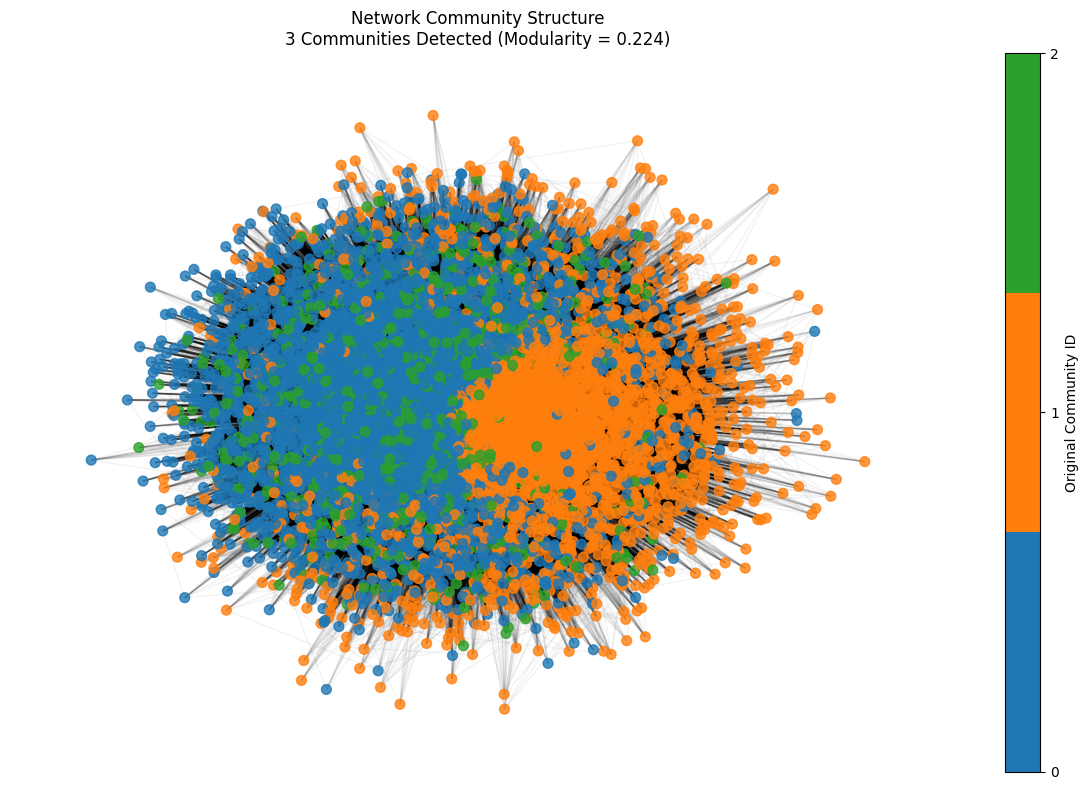

In [24]:
# Usage example with your data
if isinstance(communities, list):
    # Convert list of communities to partition dict
    partition = {node: i for i, comm in enumerate(communities) for node in comm}
else:
    # Assume communities is already a partition dict
    partition = {node: comm_id for comm_id, nodes in communities.items() for node in nodes}

visualize_communities(G, partition, modularity)

In [25]:
def analyze_communities(G, communities):
    print("\nCommunity Statistics:")

    # Convert to partition format if needed
    if isinstance(communities, list):
        partition = {node: i for i, comm in enumerate(communities) for node in comm}
        communities_dict = {i: comm for i, comm in enumerate(communities)}
        num_communities = len(communities)
    else:
        partition = {node: comm_id for comm_id, nodes in communities.items() for node in nodes}
        communities_dict = communities
        num_communities = len(communities)

    # Print number of communities FIRST
    print(f"- Total number of communities: {num_communities}")

    # 1. Size distribution
    sizes = [len(comm) for comm in communities_dict.values()]
    print(f"- Largest community: {max(sizes)} nodes")
    print(f"- Average size: {sum(sizes)/len(sizes):.1f} nodes")

    # 2. Top nodes per community (by degree)
    print("\nTop Nodes by Community (showing first 5 largest communities):")
    for comm_id, nodes in sorted(communities_dict.items(), key=lambda x: len(x[1]), reverse=True)[:5]:
        top_nodes = sorted(nodes, key=lambda x: G.degree(x), reverse=True)[:3]
        print(f"Community {comm_id} ({len(nodes)} nodes): {', '.join(str(n) for n in top_nodes)}")


In [26]:
# Usage
print(f"\nRunning community analysis on network with {len(G.nodes())} nodes and {len(G.edges())} edges")
analyze_communities(G, communities)


Running community analysis on network with 8010 nodes and 1237243 edges

Community Statistics:
- Total number of communities: 3
- Largest community: 4296 nodes
- Average size: 2670.0 nodes

Top Nodes by Community (showing first 5 largest communities):
Community 0 (4296 nodes): water, onion, olive oil
Community 1 (2779 nodes): salt, butter, sugar
Community 2 (935 nodes): vegetable oil, oil, cornstarch


In [27]:
def compute_assortativity(G):
    """
    Compute and print the degree assortativity coefficient of the full graph.
    """
    assortativity = nx.degree_assortativity_coefficient(G)
    print(f"Degree Assortativity Coefficient: {assortativity:.4f}")


In [28]:
compute_assortativity(G)

Degree Assortativity Coefficient: -0.3206


In [29]:
def plot_degree_correlation(G):
    """
    Plot the degree-degree correlation for the full graph.
    """
    # Compute average neighbor degree
    avg_neighbor_degree = nx.average_neighbor_degree(G)

    # Debugging: Print sample data
    print("Sample avg_neighbor_degree:", list(avg_neighbor_degree.items())[:10])

    # Map node labels to their degree values
    node_degrees = dict(G.degree())

    # Prepare cleaned data: Use node degrees as keys instead of labels
    cleaned_data = {}
    for node_label, avg_deg in avg_neighbor_degree.items():
        if node_label in node_degrees:  # Ensure the node exists
            try:
                node_degree = node_degrees[node_label]  # Get numeric degree
                cleaned_data[node_degree] = float(avg_deg)  # Ensure valid float values
            except (ValueError, TypeError):
                continue  # Skip invalid entries

    # Ensure valid data exists
    if not cleaned_data:
        print("Error: No valid data after filtering. Check graph data.")
        return

    # Prepare data for plotting
    x, y = zip(*sorted(cleaned_data.items()))

    # Plot degree-degree correlation
    plt.figure(figsize=(8, 6))
    plt.scatter(x, y, alpha=0.5, s=10, label="Avg Neighbor Degree")
    plt.xlabel("Node Degree")
    plt.ylabel("Average Neighbor Degree")
    plt.title("Degree-Degree Correlation (Full Graph)")

    # Apply log scale only if values are positive
    if all(i > 0 for i in x) and all(i > 0 for i in y):
        plt.xscale("log")
        plt.yscale("log")

    plt.grid(True, linestyle="--", linewidth=0.5)
    plt.legend()
    plt.show()

Sample avg_neighbor_degree: [('winter squash', 1811.194357366771), ('mexican seasoning', 1843.5657894736842), ('mixed spice', 1260.239263803681), ('honey', 503.83413461538464), ('butter', 358.7666817975488), ('olive oil', 409.42628550880977), ('salt', 333.00615090213233), ('prepared pizza crust', 1401.1820083682007), ('eggs', 405.4682256337023), ('milk', 420.18620429702224)]


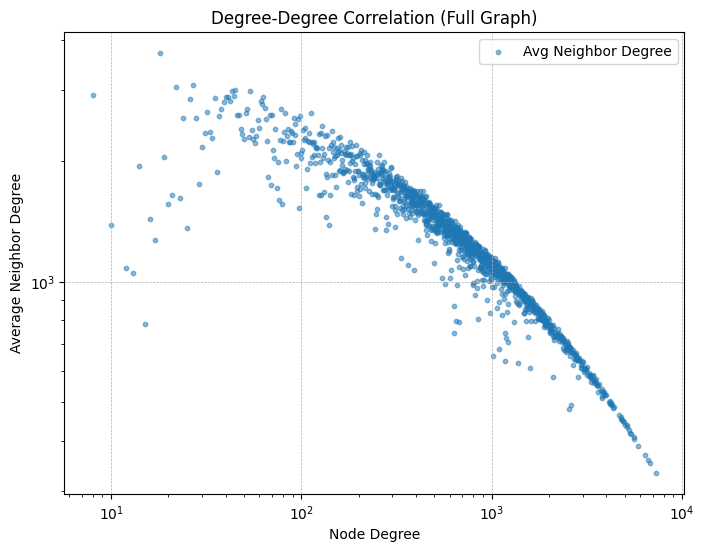

In [30]:
plot_degree_correlation(G)

In [31]:
%env NX_CUGRAPH_AUTOCONFIG=True I
import networkx as nx
print("using networkx version {nx.__version___}")
nx.config.warnings_to_ignore.add("cache")

env: NX_CUGRAPH_AUTOCONFIG=True I
using networkx version {nx.__version___}


In [32]:

%%time
bc_results = nx.betweenness_centrality(G, k=500)

CPU times: user 5min 17s, sys: 130 ms, total: 5min 18s
Wall time: 5min 18s


In [33]:
%%time
eigenvector_results = nx.eigenvector_centrality(G, max_iter=100, tol=1e-4)


CPU times: user 4.76 s, sys: 78 µs, total: 4.76 s
Wall time: 4.76 s


In [34]:
%%time
katz_results = nx.katz_centrality(G, alpha=0.001, beta=1.0, max_iter=100, tol=1e-4)

CPU times: user 3min 30s, sys: 60.5 ms, total: 3min 30s
Wall time: 3min 30s


In [35]:
%%time
hubs, authorities = nx.hits(G, max_iter=100, tol=1e-4)

CPU times: user 4.86 s, sys: 297 ms, total: 5.15 s
Wall time: 4.84 s


In [36]:
%%time
pagerank_results = nx.pagerank(G, alpha=0.85, max_iter=100, tol=1e-4)

CPU times: user 3.97 s, sys: 297 ms, total: 4.27 s
Wall time: 4.02 s


In [37]:
def compute_closeness_top_n(G, top_n=1000):
    """Compute closeness centrality and return the top N nodes."""
    start_time = time.time()

    # Use the Largest Connected Component (LCC) to avoid infinite distances
    if not nx.is_connected(G):
        G = G.subgraph(max(nx.connected_components(G), key=len)).copy()

    # Compute closeness centrality
    closeness = nx.closeness_centrality(G)

    # Get top N nodes based on closeness score
    top_nodes = sorted(closeness.items(), key=lambda x: x[1], reverse=True)[:top_n]

    end_time = time.time()
    print(f"Computed closeness centrality in {end_time - start_time:.2f} seconds.")

    return dict(top_nodes)

# Compute top 1000 nodes with highest closeness centrality
closeness_results = compute_closeness_top_n(G, top_n=1000)

Computed closeness centrality in 633.68 seconds.


In [38]:
def plot_distribution(data, title):
    """Plots the distribution of centrality scores with a log-scaled y-axis."""
    values = list(data.values())
    plt.figure(figsize=(8, 5))
    sns.histplot(values, bins=50, kde=False)
    plt.yscale('log')  # Corrected this line
    plt.title(f"Distribution of {title}")
    plt.xlabel("Centrality Score")
    plt.ylabel("Frequency (Log Scale)")
    plt.show()

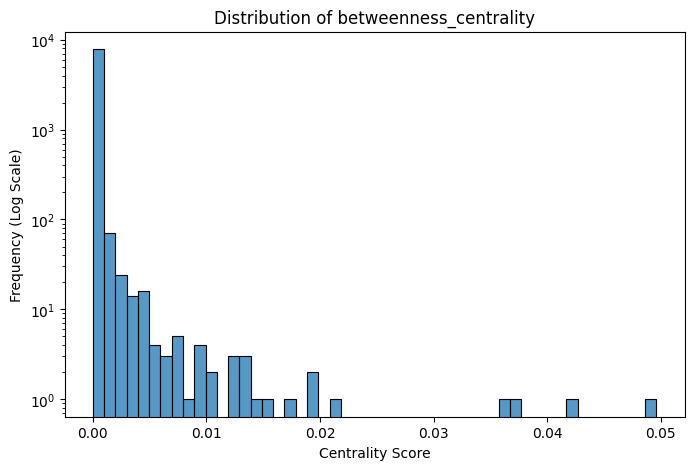

In [39]:
plot_distribution(bc_results,"betweenness_centrality")

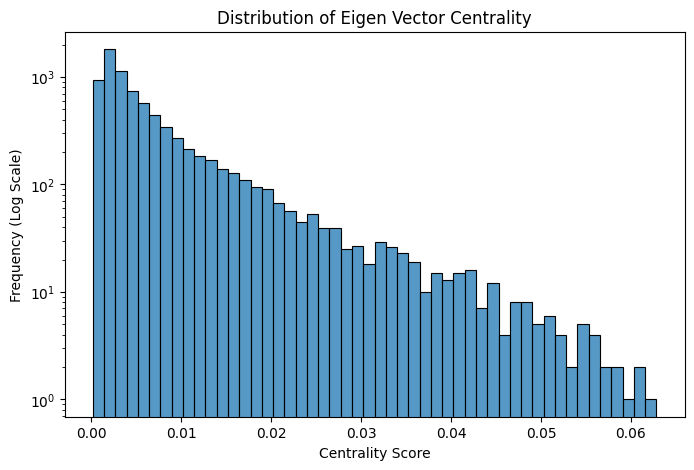

In [40]:
plot_distribution(eigenvector_results,"Eigen Vector Centrality")

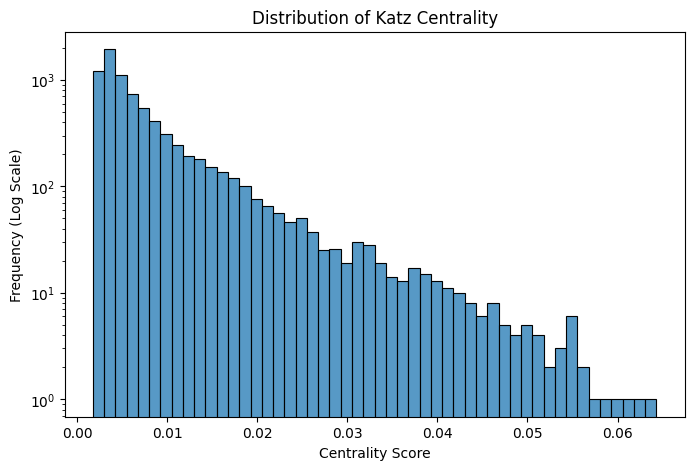

In [41]:
plot_distribution(katz_results,"Katz Centrality")

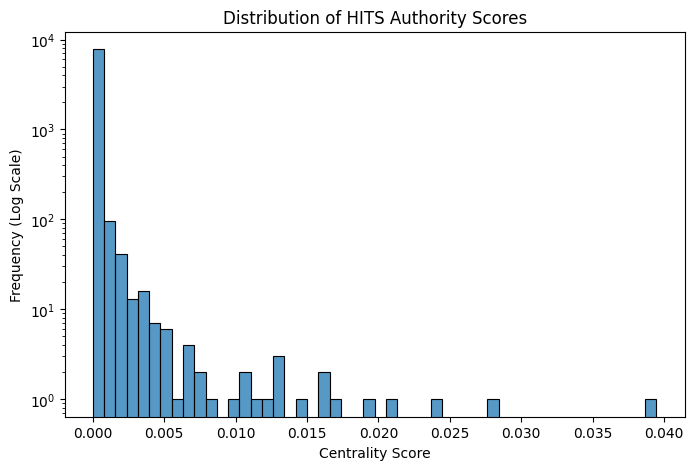

In [42]:
plot_distribution(authorities, "HITS Authority Scores")

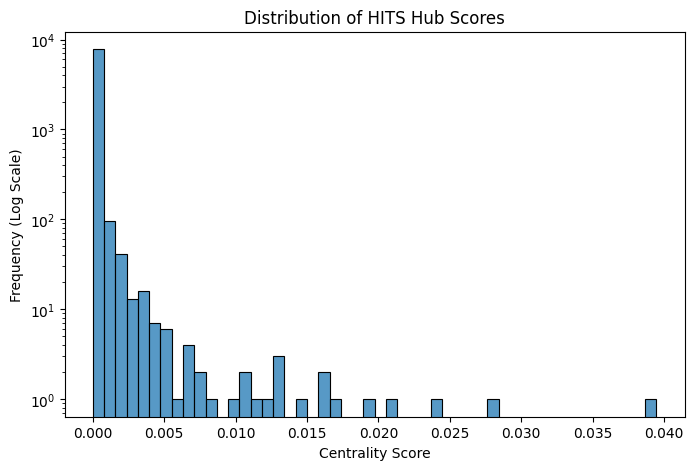

In [43]:
plot_distribution(hubs, "HITS Hub Scores")

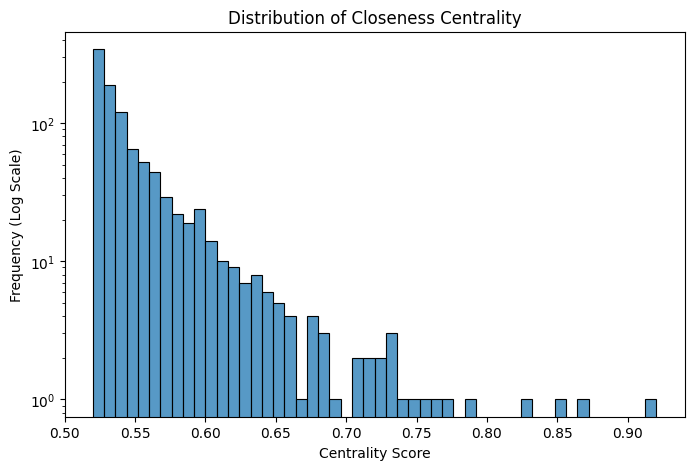

In [44]:
plot_distribution(closeness_results,"Closeness Centrality")

In [45]:
def get_top_nodes(centrality_dict, top_n=5):
    """Returns the top N nodes with the highest centrality scores."""
    return sorted(centrality_dict.items(), key=lambda x: x[1], reverse=True)[:top_n]

In [46]:
top_eigenvector = get_top_nodes(eigenvector_results, 5)
top_katz = get_top_nodes(katz_results, 5)
top_betweenness = get_top_nodes(bc_results, 5)
top_closeness = get_top_nodes(closeness_results, 5)
top_hubs = get_top_nodes(hubs, 5)
top_authorities = get_top_nodes(authorities, 5)

In [47]:
print("Top 5 Eigenvector Centrality Nodes:", top_eigenvector)
print("Top 5 Katz Centrality Nodes:", top_katz)
print("Top 5 Betweenness Centrality Nodes:", top_betweenness)
print("Top 5 Closeness Centrality Nodes:", top_closeness)
print("Top 5 HITS Hubs:", top_hubs)
print("Top 5 HITS Authorities:", top_authorities)

Top 5 Eigenvector Centrality Nodes: [('salt', 0.0628397065532597), ('water', 0.06126384655657543), ('butter', 0.060361420506585765), ('sugar', 0.05927736705033944), ('onion', 0.058754586416387984)]
Top 5 Katz Centrality Nodes: [('salt', 0.06431759258670608), ('water', 0.06221167920704937), ('butter', 0.06119836126914343), ('sugar', 0.05990927459918341), ('onion', 0.05867339001190157)]
Top 5 Betweenness Centrality Nodes: [('salt', 0.049629031954331077), ('water', 0.041800774962862934), ('butter', 0.0370462923979304), ('sugar', 0.03614127238398601), ('onion', 0.021785047567806158)]
Top 5 Closeness Centrality Nodes: [('salt', 0.9203631349115146), ('water', 0.86790203727785), ('butter', 0.8512062918482304), ('sugar', 0.8281460035156654), ('onion', 0.7896864523762571)]
Top 5 HITS Hubs: [('salt', 0.03946472371913607), ('butter', 0.028205775650744617), ('sugar', 0.024421406280067157), ('eggs', 0.021272491538647458), ('flour', 0.019019197454107118)]
Top 5 HITS Authorities: [('salt', 0.03946472

In [48]:
global_clustering = nx.transitivity(G)
print(f"Global Clustering Coefficient: {global_clustering}")

Global Clustering Coefficient: 0.2372539139319927


In [49]:
# Compute Local Clustering Coefficients
local_clustering = nx.clustering(G)

In [50]:
print(f"Local Clustering Coefficient: {local_clustering}")

Local Clustering Coefficient: {'winter squash': 0.6959641962895053, 'mexican seasoning': 0.7245555942837225, 'mixed spice': 0.4509909247688785, 'honey': 0.10138219708879723, 'butter': 0.052004759450115165, 'olive oil': 0.06828971038802685, 'salt': 0.044828720242377405, 'prepared pizza crust': 0.5274422602913958, 'eggs': 0.06620783086816814, 'milk': 0.07102133590163252, 'salt and pepper': 0.08435147262300853, 'cheese': 0.20858249585727248, 'ground beef': 0.1679657041919601, 'yellow onions': 0.30284669334365993, 'diced tomatoes': 0.18524691924209286, 'tomato paste': 0.15012135264128432, 'tomato soup': 0.46322114901232664, 'rotel tomatoes': 0.5389698394907072, 'kidney beans': 0.321084116290824, 'water': 0.0503936563760445, 'chili powder': 0.13032637380023027, 'ground cumin': 0.13849049297537333, 'lettuce': 0.2265448898657866, 'cheddar cheese': 0.13723950047924435, 'spreadable cheese with garlic and herbs': 0.7491956241956242, 'new potatoes': 0.4187796411284408, 'shallots': 0.1945873882309

In [51]:
# Select Top 10 Nodes by Degree for Local Clustering
top_nodes = sorted(G.degree(), key=lambda x: x[1], reverse=True)[:10]
top_local_clustering = {node: local_clustering[node] for node, _ in top_nodes}

In [52]:
# Print Local Clustering for Top Nodes
print("Top 10 Nodes by Degree and Their Local Clustering Coefficients:")
for node, coeff in top_local_clustering.items():
    print(f"{node}: {coeff}")


Top 10 Nodes by Degree and Their Local Clustering Coefficients:
salt: 0.044828720242377405
water: 0.0503936563760445
butter: 0.052004759450115165
sugar: 0.055242876382681966
onion: 0.06213466969859363
eggs: 0.06620783086816814
olive oil: 0.06828971038802685
garlic cloves: 0.07132639032181404
milk: 0.07102133590163252
flour: 0.07345039167308066


In [53]:
# Create a Random Graph for Comparison (same number of nodes & similar density)
random_graph = nx.erdos_renyi_graph(n=G.number_of_nodes(), p=nx.density(G))


In [54]:
# Compute Global Clustering Coefficient for Random Graph
random_global_clustering = nx.transitivity(random_graph)
print(f"Random Graph Clustering Coefficient: {random_global_clustering}")


Random Graph Clustering Coefficient: 0.03858775723694576


In [55]:
# Compare Results
print("\nComparison:")
print(f"Original Network Clustering: {global_clustering}")
print(f"Random Graph Clustering: {random_global_clustering}")


Comparison:
Original Network Clustering: 0.2372539139319927
Random Graph Clustering: 0.03858775723694576


In [56]:
ingredients = ['salt', 'water', 'butter', 'sugar', 'onion', 'eggs', 'olive oil', 'garlic cloves', 'milk', 'flour']
coeffs = [0.0448, 0.0504, 0.0520, 0.0552, 0.0621, 0.0662, 0.0683, 0.0713, 0.0710, 0.0735]

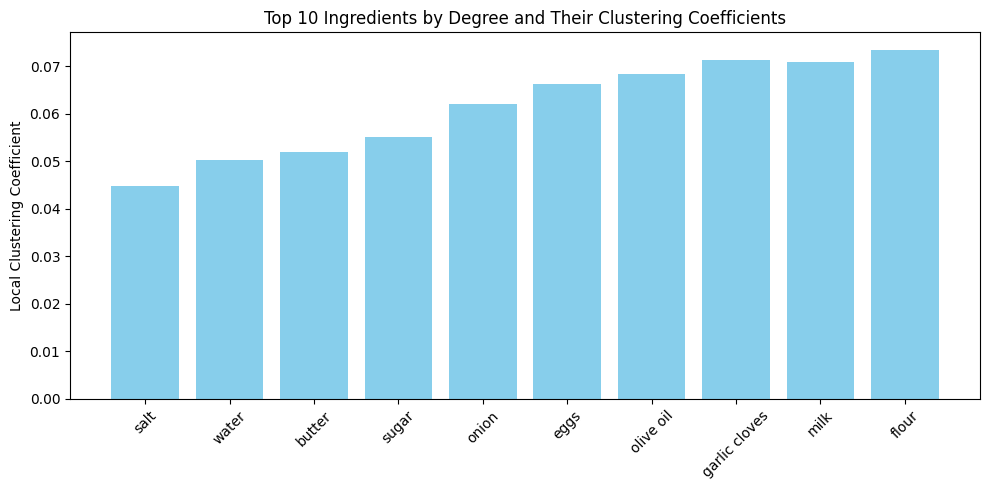

In [57]:
plt.figure(figsize=(10, 5))
plt.bar(ingredients, coeffs, color='skyblue')
plt.xticks(rotation=45)
plt.ylabel('Local Clustering Coefficient')
plt.title('Top 10 Ingredients by Degree and Their Clustering Coefficients')
plt.tight_layout()
plt.savefig('clustering_coeff_plot.png')
plt.show()